In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-07-23 11:07:49.464922: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 11:07:49.467972: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 11:07:49.506577: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 11:07:49.507466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 11:07:50.220714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# len(weights_ann_1[0].ravel())

In [4]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [5]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [6]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [7]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [8]:
samp_ann =  ann(hidden = 8, input_shape = 64, output_shape = 1)

In [9]:
weights_ann_1 = samp_ann.get_weights()

In [10]:
h1  = samp_ann.layers[1].output.shape[-1]

In [11]:
h1

8

In [12]:
samp_ann.count_params()

529

In [13]:
hidden_neurons = h1

In [14]:
samp_ann_params = samp_ann.count_params()

In [15]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
#     initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
#     initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(2, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
#     initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
#     initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [16]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [17]:
from scipy.stats import beta

In [18]:
fudging_beta = beta(1,9)

In [19]:
def forward_operation(data1, data2, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
#     model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2,
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2

In [20]:
def forward_operation_test(data1, data2, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
#     model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 
    
    return X_t, initial_ensembles, final_output, model_1, model_2

In [21]:
total_weights = 2*(samp_ann.count_params() + 1 + 1)

In [22]:
reduction = 10

In [23]:
size_ens = total_weights//reduction
# total_weights//reduction

In [24]:
size_ens

106

In [25]:
G_t = [[1, 1]]
G_t = np.array(G_t).T

In [26]:
G_t.shape

(2, 1)

In [27]:
def get_predictions(data1, data2, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2

In [28]:
def get_predictions_test(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, w1, w2 = forward_operation_test(data1, data2, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2

In [29]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [30]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [31]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [32]:
def get_updated_ensemble(data1, data2, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [33]:
target_dim = 1

In [34]:
lambda_D = 1

In [35]:
from joblib import Parallel, delayed

In [36]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [37]:
# idx = 1

In [38]:
with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [39]:
with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [40]:
import random

In [41]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2 = catch_train[0][idxes,:], catch_train[1][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, y_train 

In [42]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2 = catch_test[0][idxes,:], catch_test[1][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, y_train

In [43]:
train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])

In [44]:
# len(train_idxes)

In [45]:
# data2_traina.shape

In [48]:
# data1_traina.shape

In [49]:
data1_traina, data2_traina, y_traina =  prepare_data_train(catch_train, idxes = train_idxes)

In [50]:
data1_test, data2_test, y_test =  prepare_data_test(catch_test, size = catch_test[0].shape[0])

In [51]:
current_test = [data1_test, data2_test, y_test]

In [52]:
from scipy.stats import pearsonr

In [53]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [54]:
batch_size = 2500

In [55]:
import random

In [56]:
from tqdm import tqdm_notebook

In [57]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    w1_catch = []
    w2_catch = []

    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, y_train = prepare_data_train(catch_train, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, y_train = prepare_data_train(catch_train, chunk)
            
            
            
            initial_ensembles = get_updated_ensemble(data1_train, data2_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2 = get_predictions(data1_traina, data2_traina, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_traina >= li_train) & (y_traina <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_traina -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_traina.reshape(y_traina.shape[0],))
        
            r_train = pearsonr_train.statistic
    
            G_u_test, _, _ = get_predictions_test(data1_test, data2_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test.statistic
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            if print_true == True: 
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
                
            w1_catch.append([w1.mean(), w1.std()])
            w2_catch.append([w2.mean(), w2.std()])
                # print(w1.mean(), w1.std())

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
                best_test_preds = averaged_targets_test
                best_li = li_test
                best_ui = ui_test
                best_residuals = (y_test -averaged_targets_test)
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
            
                # print()
                # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
                # print("done for fold" + str(idx), flush = True)
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                weights = [best_w1_weight, best_w2_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals]


In [58]:
threshold = 10

In [59]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, \
best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals = get_results(0, var_weights = 0.08, var_weight_weights = 1, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 2*1e-3, print_true = True)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.2208801687519866 30.806629311081384 41.557628101196805 -0.03346510638970445
Testing Coverage, Widths, RMSE, and Pearson R
0.22337722337722338 30.827952425556177 41.74811992508203 -0.03901483754612691
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.4717831652555841 10.851293875495164 7.5212938369227125 0.23237951849355684
Testing Coverage, Widths, RMSE, and Pearson R
0.4733772233772234 10.874515593190477 7.520870865631481 0.23153377069820733
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.7205623139827203 11.60708600939848 5.0422616611719935 -0.2038607112725591
Testing Coverage, Widths, RMSE, and Pearson R
0.7178909678909678 11.612332965844255 5.080794327663548 -0.20786294970433022
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.9498511861762071 12.90012833394218 2.643750341942685 0.3694451577159377
Testing Coverage, Widths, RMSE, and Pearson R
0.9508547008547008 12.9261

In [60]:
preds_test, _, _ = get_predictions_test(data1_test, data2_test, best_ensembles)

In [61]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

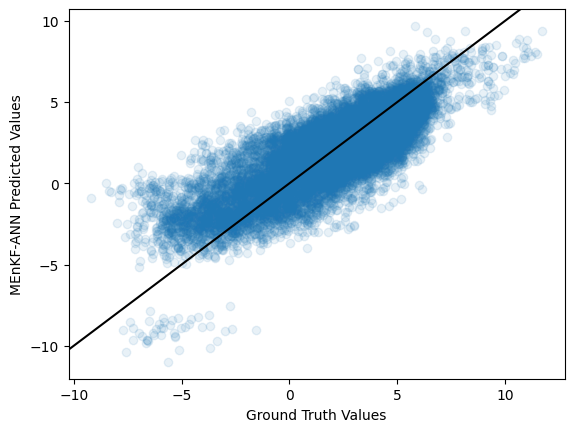

In [62]:
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values")
plt.ylabel("MEnKF-ANN Predicted Values")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
plt.show()

In [63]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,best_w1_weight, best_w2_weight]

In [64]:
items_df = pd.DataFrame(items).T

In [65]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight']

In [66]:
items_df = items_df.T

In [67]:
# items_df.columns = ["Value"]

In [68]:
items_df

,0
best_train_width,26.145899
best_coverage_train,0.999856
best_rmse_train,1.700352
best_test_width,26.123376
best_coverage_test,0.999942
best_rmse_test,1.696155
best_pearson_r,0.800963
best_w1_weight,0.957067
best_w2_weight,0.042933


In [69]:
preds_test.shape

(106, 17316)

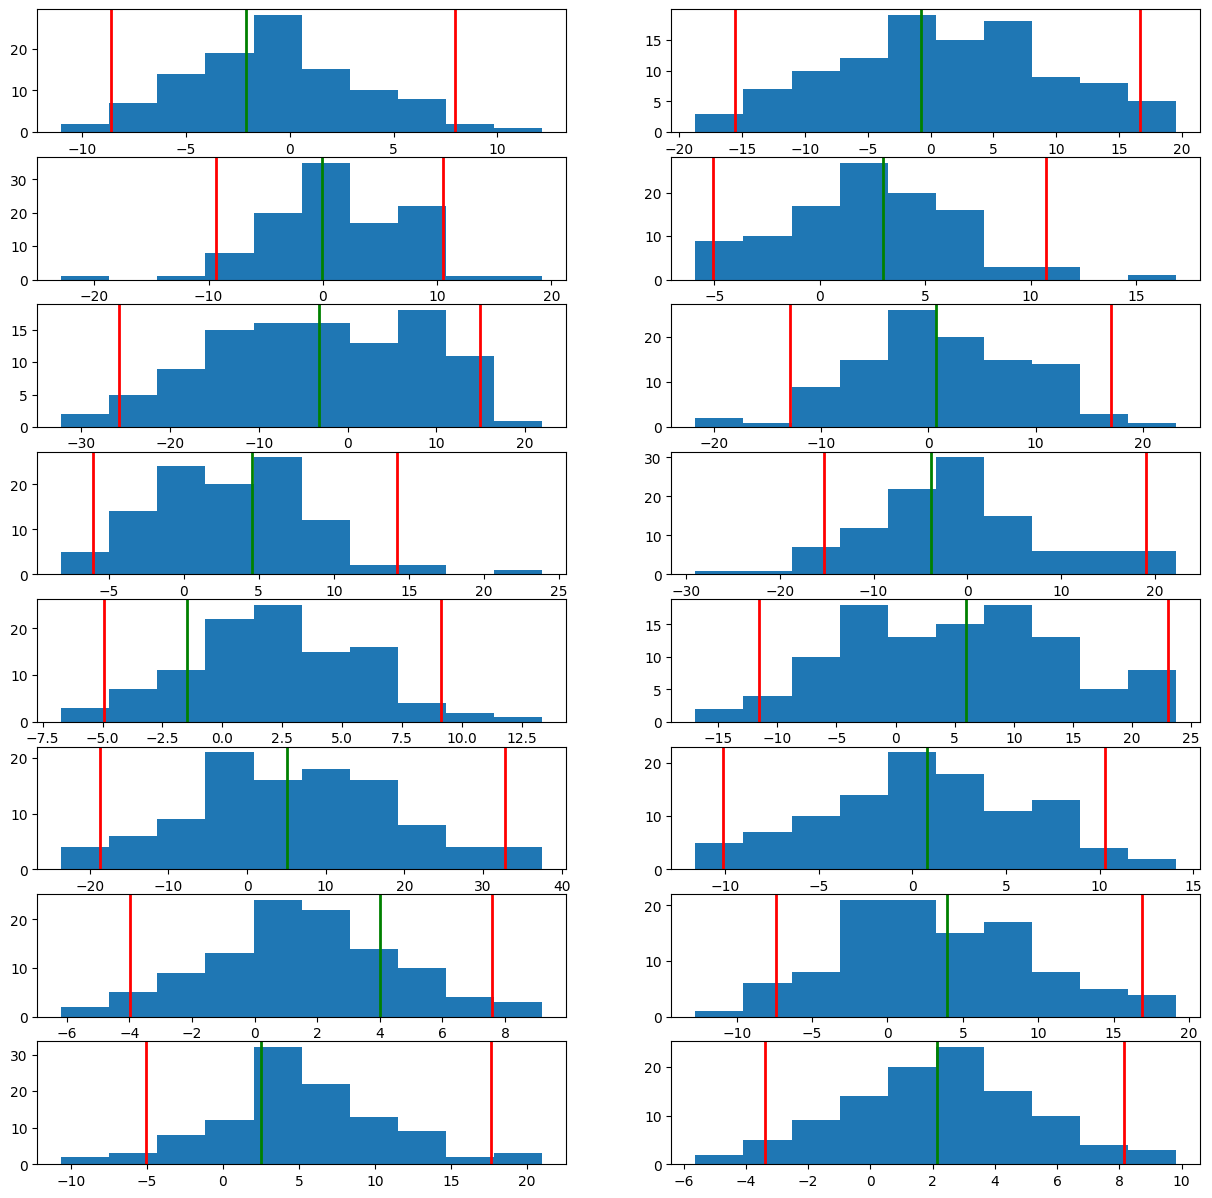

In [70]:
random_idx = random.sample(range(y_test.shape[0]), k = 16)
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=2)
    axs[idx].axvline(lis, color='red', linewidth=2)
    axs[idx].axvline(uis, color='red', linewidth=2)

# plt.title
fig.savefig('gcn_cdr_pred_intervals.png', bbox_inches='tight')
plt.show()


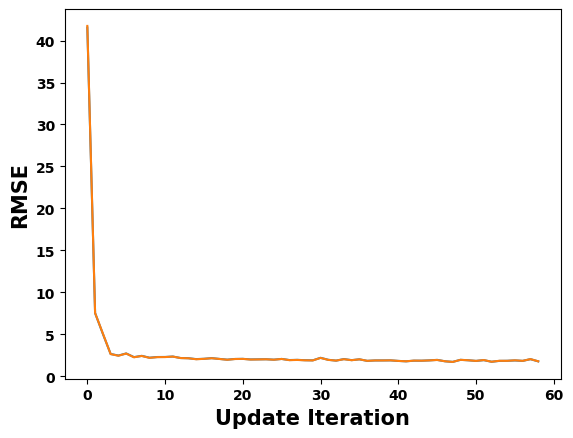

In [71]:
plt.plot(train_rmse)
plt.plot(test_rmse)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.show()

In [72]:
# plt.hist(y_train)
# plt.show()

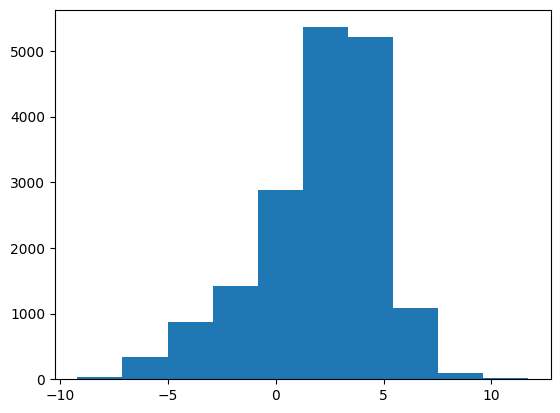

In [73]:
plt.hist(y_test)
plt.show()

In [74]:
catch = Parallel(n_jobs = 14, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 1, var_weight_weights = 1, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 2*1e-3, print_true = False) for idx in range(0,50))

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


test_coverage0.9198429198429199
test_width6.615733020408131
rmse_test1.6534869345519985
weights
[0.4015301637955853, 0.5984698362044147]


test_coverage0.9767844767844768
test_width10.206706301118416
rmse_test1.6591542924954774
weights
[0.5419165927365863, 0.45808340726341373]


test_coverage0.6438553938553938
test_width2.9753710287388517
rmse_test1.6467771274992784
weights
[0.07940037639421181, 0.9205996236057883]


test_coverage0.9737237237237237
test_width10.270681923248627
rmse_test1.6636135082889056
weights
[0.5138908911293066, 0.4861091088706934]


test_coverage0.9983252483252483
test_width16.109745684020105
rmse_test1.6864737655228135
weights
[0.8307080299531673, 0.16929197004683286]


test_coverage0.9907599907599908
test_width12.191210794108931
rmse_test1.6601226960233557
weights
[0.6891265259929497, 0.3108734740070503]


test_coverage0.8487525987525988
test_width4.916072502932436
rmse_test1.6389003407956353
weights
[0.15880508152336678, 0.8411949184766332]


test_coverage0.797

[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed: 31.6min


test_coverage0.990990990990991
test_width13.159250914549075
rmse_test1.6564804550995906
weights
[0.5348989941296857, 0.4651010058703144]


test_coverage0.6826056826056826
test_width3.2317678666294967
rmse_test1.644171480648062
weights
[0.060440051662283535, 0.9395599483377166]


test_coverage0.6586971586971587
test_width3.1487404119669757
rmse_test1.6390435317723484
weights
[0.028576820373723166, 0.9714231796262769]


test_coverage0.932028182028182
test_width6.931868265702497
rmse_test1.6526689474452962
weights
[0.25734805732614924, 0.7426519426738508]


test_coverage0.9938207438207438
test_width13.21726523946579
rmse_test1.6518886301666658
weights
[0.66733562771969, 0.3326643722803098]


test_coverage0.9723377223377223
test_width9.241456820971967
rmse_test1.6505272934172295
weights
[0.44868983314242566, 0.5513101668575743]


test_coverage0.7647840147840148
test_width3.890121862984831
rmse_test1.6430545070957805
weights
[0.1295716984331089, 0.8704283015668911]


test_coverage0.83177408

[Parallel(n_jobs=14)]: Done  30 out of  50 | elapsed: 62.7min remaining: 41.8min


test_coverage0.9915684915684916
test_width13.711807034761781
rmse_test1.6670223401450661
weights
[0.8049952321809184, 0.19500476781908158]


test_coverage0.9544352044352045
test_width8.171605946946903
rmse_test1.654544244052688
weights
[0.4554845045245961, 0.5445154954754039]


test_coverage0.7427234927234927
test_width3.962707684814832
rmse_test1.641595243521056
weights
[0.022044465245546725, 0.9779555347544535]


test_coverage0.990933240933241
test_width11.938364539102954
rmse_test1.6515996107397097
weights
[0.6844194483877999, 0.3155805516122001]


test_coverage0.9248094248094249
test_width6.303607906229215
rmse_test1.6379819369158028
weights
[0.3164553093359725, 0.6835446906640275]


test_coverage0.9987294987294987
test_width19.08025639303151
rmse_test1.698868827537972
weights
[0.9104666545636331, 0.08953334543636696]


test_coverage0.7849387849387849
test_width4.247605742675856
rmse_test1.640941864166636
weights
[0.0826285443574587, 0.9173714556425412]




[Parallel(n_jobs=14)]: Done  37 out of  50 | elapsed: 75.0min remaining: 26.3min


test_coverage0.6279163779163779
test_width2.852577076674636
rmse_test1.6344376733341972
weights
[0.06384402184257042, 0.9361559781574298]


test_coverage0.5904365904365905
test_width2.6460328256145282
rmse_test1.6424220856378453
weights
[0.04823909964007485, 0.9517609003599251]


test_coverage0.7566990066990067
test_width3.8020211681273097
rmse_test1.6357464500759415
weights
[0.14874382786479193, 0.851256172135208]


test_coverage0.8611688611688612
test_width5.047936468787415
rmse_test1.636639924173207
weights
[0.2330725725821448, 0.7669274274178554]


test_coverage0.9652922152922153
test_width8.784954461177135
rmse_test1.6494351700580987
weights
[0.4672781187877593, 0.5327218812122407]


test_coverage0.9950912450912451
test_width13.422082759888225
rmse_test1.655393013286748
weights
[0.6639960342771094, 0.33600396572289065]


test_coverage0.9760337260337261
test_width9.292362501319634
rmse_test1.642734953820371
weights
[0.48967812390067905, 0.510321876099321]




[Parallel(n_jobs=14)]: Done  44 out of  50 | elapsed: 85.8min remaining: 11.7min


test_coverage0.7668052668052668
test_width4.138022752946235
rmse_test1.6416605807350837
weights
[0.04429448749032649, 0.9557055125096736]


test_coverage0.988911988911989
test_width12.118208782236515
rmse_test1.6661974630959995
weights
[0.6415034787691202, 0.3584965212308798]


test_coverage0.967082467082467
test_width8.92422080486081
rmse_test1.6509171122012845
weights
[0.2676223433482773, 0.7323776566517226]


test_coverage0.8845576345576346
test_width5.611934487786561
rmse_test1.6538653936879595
weights
[0.10229044085617643, 0.8977095591438237]


test_coverage0.9194386694386695
test_width6.737744910012924
rmse_test1.646281847153667
weights
[0.41563103152820025, 0.5843689684717998]


test_coverage0.7726380226380226
test_width4.085615926372627
rmse_test1.6418844183915948
weights
[0.07898781161231909, 0.9210121883876808]




[Parallel(n_jobs=14)]: Done  50 out of  50 | elapsed: 100.0min finished


In [75]:
with open("..//Data//DeepCDR_run_config3_plots_from_jupyter_all_data.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [76]:
with open("..//Data//DeepCDR_run_config3_plots_from_jupyter_all_data.pickle", "rb") as f: 
    catch = pickle.load(f)

In [78]:
all_metrics = []
all_weights = []
for i in range(0,50):
    item = catch[i]
    metrics = item[:7]
    weights = item[-8:-6]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [79]:
all_metrics_df = pd.DataFrame(all_metrics)

In [80]:
# all_metrics_df.head()

In [81]:
all_weights_df = pd.DataFrame(all_weights)

In [82]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [83]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                    "DeepCDR_Drugs", "DeepCDR_Omics"]

In [84]:
all_df.mean()

train_width       8.364616
coverage_train    0.882643
rmse_train        1.644979
test_width        8.368590
coverage_test     0.880992
rmse_test         1.651233
pearson_r         0.812848
DeepCDR_Drugs     0.380502
DeepCDR_Omics     0.619498
dtype: float64

In [85]:
all_df.std()

train_width       4.837825
coverage_train    0.122515
rmse_train        0.012449
test_width        4.844184
coverage_test     0.124000
rmse_test         0.013318
pearson_r         0.003047
DeepCDR_Drugs     0.281884
DeepCDR_Omics     0.281884
dtype: float64

In [86]:
with open("..//Data//DeepCDR_run_plot_from_jupyter_test_features_and_ground_truth_all_data.pickle", "wb") as f: 
    pickle.dump(current_test, f)

In [87]:
add_preds = np.zeros((y_test.shape[0], y_test.shape[1]))
for item in catch: 
    preds = item[-4]
    add_preds+= preds

In [88]:
averaged_preds = add_preds/50

In [89]:
from sklearn.metrics import mean_squared_error

In [90]:
mse = mean_squared_error(y_test, averaged_preds)

In [91]:
np.sqrt(mse)

1.6241694835623723

In [92]:
from scipy.stats import pearsonr

In [93]:
pearsonr_test = pearsonr(y_test.reshape(y_test.shape[0],), 
                                 averaged_preds.reshape(averaged_preds.shape[0],))

In [94]:
pearsonr_test.statistic

0.8191136674487742

In [95]:
all_li = np.zeros((y_test.shape[0], len(catch)))
all_ui = np.zeros((y_test.shape[0], len(catch)))
for i, item in enumerate(catch): 
    preds = item[-3:-1]
    all_li[:,i] =  preds[0][:,0]
    all_ui[:,i] =  preds[1][:,0]

In [96]:
li = np.median(all_li, axis = 1).reshape(-1,1)

In [97]:
li_mean = np.mean(all_li, axis = 1).reshape(-1,1)

In [98]:
ui = np.median(all_ui, axis = 1).reshape(-1,1)

In [99]:
ui_mean = np.mean(all_ui, axis = 1).reshape(-1,1)

In [100]:
combo = np.hstack((y_test, li, ui))

In [101]:
combo_mean = np.hstack((y_test, li_mean, ui_mean))

In [102]:
combo_mean_df = pd.DataFrame(combo_mean)

In [103]:
combo_mean_df.columns = ["IC50", "LI_IC50_Pred", "UI_IC50_Pred"]

In [104]:
combo_mean_df["coverage"] = (combo_mean_df["IC50"] >= combo_mean_df["LI_IC50_Pred"]) & (combo_mean_df["IC50"] <= combo_mean_df["UI_IC50_Pred"])

In [105]:
combo_mean_df["coverage"].mean()

0.9782282282282282

In [106]:
combo_mean_df["width"] = combo_mean_df["UI_IC50_Pred"]-combo_mean_df["LI_IC50_Pred"]

In [107]:
combo_mean_df["width"].mean()

8.368589709363908

In [108]:
combo_df = pd.DataFrame(combo)

In [109]:
combo_df.columns = ["IC50", "LI_IC50_Pred", "UI_IC50_Pred"]

In [110]:
combo_df = combo_df.sort_values("IC50").reset_index(drop = True)

In [111]:
combo_df["coverage"] = (combo_df["IC50"] >= combo_df["LI_IC50_Pred"]) & (combo_df["IC50"] <= combo_df["UI_IC50_Pred"])

In [112]:
combo_df["coverage"].mean()

0.9506237006237006

In [113]:
combo_df["width"] = combo_df["UI_IC50_Pred"]-combo_df["LI_IC50_Pred"]

In [114]:
combo_df["width"].mean()

6.768076058181752